In [1]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=5eef1a9be6c63dee96e9499a151ad7ca1df93189ce1ed903ac3c79877e64ddf7
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [49]:
import umap as ump
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score as ss
from sklearn.cluster import KMeans
from google.colab import drive
import os
from os import listdir

print('Successful imports')

Successful imports


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/MyDrive/Machine Learning in healthcare/Final project'

/content/gdrive/MyDrive/Machine Learning in healthcare/Final project


 ### IDEAS

 CLUSTERING - GMM

 DIMENSIONALITY REDUCTION - Umap + plot to observe data separation in latent space

 Study pairwise mutual information + HSIC + correlations

 Association rules, observe what usually goes together A PRIORI

 Graph analysis on graph version of latent space and run algorithms for strongly connected components. Something that accounts for intra-class noise and difference between other classes (or clusters)



## Feature selection

In [ ]:
data = pd.read_csv('Eureca_Adapted.csv', low_memory=False)

In [ ]:
all = data.columns
cols = []

In [ ]:
# series of interesting information,
mixture = ['type', 'suicide','EST_CIV', 'children', 'ideation_of_suicide', 'desire_of_death', 'Planification_of_suicide', 'tm', 'tm2',
        'tabacco_act', 'niv_edu','his_fam_suicide_behavior', 'his_fam_suicide', 'his_fam_suicide_attempt',
        'desire_of_death', 'Planification_of_suicide', 'dd_depre', 'dd_bipolar', 'dd_sz', 'dd_psychotic']

In [ ]:
# BDHI and BIS scales
BDHIS = [col for col in all if ("BDHI_" in col)] # usando subtotales BDHI_,
BIS = [col for col in all if ("BIS10_" in col)] # cogemos subtotales latentes BIS, resultado final es suma de los tres subtotales



In [ ]:
print(BDHIS)
print(BIS)

['BDHI_Impul', 'BDHI_Hostind', 'BDHI_Irritab', 'BDHI_Negativ', 'BDHI_Ressent', 'BDHI_Suspic', 'BDHI_Hostivb', 'BDHI_Culpab']
['BIS10_Impulc', 'BIS10_Impulm', 'BIS10_impulnp']


In [ ]:
# polymorphisms and other data are in the last 30 variables
extra = list(data.columns[-30:])
for col in mixture +  BDHIS +  BIS + extra:
  cols.append(col)


In [ ]:
print(f"Original data dimension: {len(all)}")
print(f"Current subset dimension: {len(cols)}")


Original data dimension: 604
Current subset dimension: 61


In [ ]:
reducedFeatures = mixture + BIS + BDHIS + extra
# save feature subset
subset = data[reducedFeatures]
subset['BIS'] = subset[BIS[0]] + subset[BIS[1]] + subset[BIS[2]]
subset.drop(columns=BIS, inplace=True)

subset.to_csv('Eureca2.0.csv', index=False)

<ipython-input-12-ed54b08e2e16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['BIS'] = subset[BIS[0]] + subset[BIS[1]] + subset[BIS[2]]
<ipython-input-12-ed54b08e2e16>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.drop(columns=BIS, inplace=True)


## Exploratory Data analysis: Understanding of our data

## Patient profiling

In this section we profile patients based on different clustering and dimensionality reduction schemes.

In [8]:
# reading feature subset
df = pd.read_csv('Eureca2.0.csv')

In [ ]:
df.head()

,type,suicide,EST_CIV,children,ideation_of_suicide,desire_of_death,Planification_of_suicide,tm,tm2,tabacco_act,...,TPH1_T8687,TPH2_8997,TPH2_9000_Eco72_1,TPH2_9000_Aci_I,TPH2_Intron5,TPH2_Exon7,TPH2_Intron9,MAOA_Promo,MAOA_promo_activite,BIS
0,12,0,2,1,2,2,2,1,,1,...,,,AA,GG,,GG,,2 3,B H,311228
1,7,,,1,,2,,1,,,...,,,AA,,,AG,,2,H,281931
2,12,0,2,1,2,2,2,1,,0,...,,,AA,GG,,GG,,2,H,152418
3,12,0,2,1,1,1,0,1,,1,...,,,,,,,,,,40
4,11,,3,,,,,1,,,...,,,,,,,,2,H,


#### UMAP + GMM


UMAP works by modeling the relationships between data points in the high-dimensional space and finding a low-dimensional representation that preserves these relationships. Unlike traditional methods like t-SNE, UMAP provides a more scalable and computationally efficient solution.


______
1. The first issue tackled lies in the fact that UMAP only works with numeric variables, but that is not the case in our dataset. The variables corresponding to the polymorphisms take a very small subset of different nucleotide combinations, dummy variable encoding is therefore used.

In [ ]:

from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA


class Embedder:
    def __init__(self, model_name, num_components=1, max_length=32):
        self.model = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.num_components = num_components
        self.max_length = max_length

    def _get_bert_embeddings(self, documents):
        tokenized_texts = [self.tokenizer(document, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length) for document in documents]
        input_ids = torch.cat([t['input_ids'] for t in tokenized_texts], dim=0)
        attention_mask = torch.cat([t['attention_mask'] for t in tokenized_texts], dim=0)

        with torch.no_grad():
            output = self.model(input_ids, attention_mask=attention_mask)

        embeddings = output.last_hidden_state.mean(dim=1).numpy()
        print('Embeddings successfully completed')
        return embeddings
    def fit_transform(self, documents):
        embeddings = self._get_bert_embeddings(documents)

        # Reduce dimensionality to 1D using PCA
        pca = PCA(n_components=self.num_components)
        reduced_embeddings = pca.fit_transform(embeddings)

        return reduced_embeddings

In [ ]:
df.head()

,type,suicide,EST_CIV,children,ideation_of_suicide,desire_of_death,Planification_of_suicide,tm,tm2,tabacco_act,...,TPH1_T8687,TPH2_8997,TPH2_9000_Eco72_1,TPH2_9000_Aci_I,TPH2_Intron5,TPH2_Exon7,TPH2_Intron9,MAOA_Promo,MAOA_promo_activite,BIS
0,12,0,2,1,2,2,2,1,,1,...,,,AA,GG,,GG,,2 3,B H,311228
1,7,,,1,,2,,1,,,...,,,AA,,,AG,,2,H,281931
2,12,0,2,1,2,2,2,1,,0,...,,,AA,GG,,GG,,2,H,152418
3,12,0,2,1,1,1,0,1,,1,...,,,,,,,,,,40
4,11,,3,,,,,1,,,...,,,,,,,,2,H,


In [ ]:
import copy

# don't run this unless you don't have copy of dataset, there is a reading cell below already
embd = Embedder('bert-base-uncased')
scols= df.select_dtypes(include=['object']).columns
df2 = df.copy()
for col in scols:
  # compute embeddings of list of unique values and perform replacement
  documents = df[col].unique().tolist()
  values = embd.fit_transform(documents)
  rep = dict(zip(documents, values))
  df2[col] = df2[col].replace(rep)

Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings suc

In [ ]:
# saving encoded version
df2.to_csv('Eureca2.0_embed.csv')

In [5]:
# read
df2 = pd.read_csv('Eureca2.0_embed.csv')

In [ ]:
len(df.columns)

59

In [36]:
# loading read_csv
reducer = ump.UMAP(random_state=42)
embeddings = reducer.fit_transform(df2)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
# 3d version
"""
reducer = ump.UMAP(n_components=3)
embeddings = reducer.fit_transform(df2)
"""

2. Studying the correlations between the original features and the UMAP dimensions, helps to understand which variables have the most impact in the components of the reduced data. The following code displays, for both components, the 10 features with the highest correlation with the UMAP component in absolute value

In [37]:
print('CORRELATION STUDY FOR 2-D UMAP EMBEDDINGS')
correlations = np.zeros((df2.shape[1], embeddings.shape[1]))

# Calculate correlations
for i in range(df.shape[1]):
    for j in range(embeddings.shape[1]):
        correlations[i, j] = np.corrcoef(df2.iloc[:, i], embeddings[:, j], rowvar=False)[0, 1]

# Create DataFrames to store the results for UMAP1 and UMAP2
correlation_df_umap1 = pd.DataFrame(correlations[:, 0], columns=['UMAP1'], index=df2.columns)
correlation_df_umap2 = pd.DataFrame(correlations[:, 1], columns=['UMAP2'], index=df2.columns)

# Get top 10 correlations for UMAP1
top_correlations_umap1 = correlation_df_umap1.abs().nlargest(10, 'UMAP1')

# Print the top 10 correlations with sign for UMAP1
print("UMAP1:")
for feature, correlation in top_correlations_umap1.iterrows():
    sign = '-' if correlation_df_umap1.loc[feature, 'UMAP1'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP1']:.4f}")

# Get top 10 correlations for UMAP2
top_correlations_umap2 = correlation_df_umap2.abs().nlargest(10, 'UMAP2')

# Print the top 10 correlations with sign for UMAP2
print("\nUMAP2:")
for feature, correlation in top_correlations_umap2.iterrows():
    sign = '-' if correlation_df_umap2.loc[feature, 'UMAP2'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP2']:.4f}")

CORRELATION STUDY FOR 2-D UMAP EMBEDDINGS
UMAP1:
Feature: dd_sz, Correlation: (-) 0.2530
Feature: COMT, Correlation: (-) 0.1442
Feature: VHTTP_snippassocie, Correlation: (-) 0.1421
Feature: VHTTP_mutation_seule, Correlation: (-) 0.1412
Feature: VHTTP_LPR, Correlation: (-) 0.1394
Feature: HT1B_861, Correlation: (-) 0.1381
Feature: HT1A, Correlation: (-) 0.1368
Feature: DOS_testosterone, Correlation: (+) 0.1347
Feature: TPH2_9000_Eco72_1, Correlation: (-) 0.1302
Feature: TPH2_9000_Aci_I, Correlation: (-) 0.1297

UMAP2:
Feature: his_fam_suicide_behavior, Correlation: (+) 0.3174
Feature: his_fam_suicide_attempt, Correlation: (+) 0.3057
Feature: his_fam_suicide, Correlation: (+) 0.3022
Feature: dd_sz, Correlation: (+) 0.2971
Feature: dd_psychotic, Correlation: (+) 0.2674
Feature: type, Correlation: (-) 0.2501
Feature: Unnamed: 0, Correlation: (+) 0.2316
Feature: EST_CIV, Correlation: (+) 0.1669
Feature: niv_edu, Correlation: (+) 0.1642
Feature: TPH1_Intron3, Correlation: (-) 0.1548


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:

# 3d version
"""
correlations = np.zeros((df2.shape[1], embeddings.shape[1]))
for i in range(df2.shape[1]):
    for j in range(embeddings.shape[1]):
        correlations[i, j] = np.corrcoef(df2.iloc[:, i], embeddings[:, j], rowvar=False)[0, 1]

# Create DataFrame to store the results for UMAP dimensions
correlation_df_umap = pd.DataFrame(correlations, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=df2.columns)

# Get top 10 correlations for each UMAP dimension
top_correlations_umap1 = correlation_df_umap.abs().nlargest(10, 'UMAP1')
top_correlations_umap2 = correlation_df_umap.abs().nlargest(10, 'UMAP2')
top_correlations_umap3 = correlation_df_umap.abs().nlargest(10, 'UMAP3')

# Print the top 10 correlations with sign for each UMAP dimension
print("UMAP1:")
for feature, correlation in top_correlations_umap1.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP1'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP1']:.4f}")

print("\nUMAP2:")
for feature, correlation in top_correlations_umap2.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP2'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP2']:.4f}")

print("\nUMAP3:")
for feature, correlation in top_correlations_umap3.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP3'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP3']:.4f}")
"""

UMAP1:
Feature: Unnamed: 0, Correlation: (-) 0.4049
Feature: HT1A, Correlation: (-) 0.1626
Feature: HT1B_861, Correlation: (-) 0.1626
Feature: COMT, Correlation: (-) 0.1600
Feature: TPH1_Intron7, Correlation: (-) 0.1343
Feature: dd_sz, Correlation: (-) 0.1340
Feature: TPH1_promo, Correlation: (-) 0.1305
Feature: TPH1_Intron4, Correlation: (-) 0.1266
Feature: TPH2_9000_Eco72_1, Correlation: (-) 0.1247
Feature: BIS, Correlation: (-) 0.1240

UMAP2:
Feature: dd_sz, Correlation: (+) 0.5219
Feature: Unnamed: 0, Correlation: (-) 0.3902
Feature: TPH1_promo, Correlation: (+) 0.3655
Feature: TPH1_Intron4, Correlation: (+) 0.3618
Feature: TPH1_Intron7, Correlation: (+) 0.3588
Feature: TPH2_9000_Eco72_1, Correlation: (+) 0.3529
Feature: TPH2_9000_Aci_I, Correlation: (+) 0.3514
Feature: TPH2_Exon7, Correlation: (+) 0.3398
Feature: children, Correlation: (-) 0.3027
Feature: VHTTP_snippassocie, Correlation: (+) 0.2927

UMAP3:
Feature: his_fam_suicide_behavior, Correlation: (-) 0.3070
Feature: his_fam

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


3. Fitting GMM to data based on optimal BIC.

In [38]:

# UMAP + GMM clustering through optimal Bayesian Information Criterion

# this cell is the same for 2d and 3d data
# we need to encode string variables

bics = []
lls = [] # log-likelihoods
aics = []
sscores = []
ks = range(1,7)
for ns in ks:
  gmm = GMM(n_components=ns, random_state=42)
  gmm.fit(embeddings)
  labels = gmm.predict(embeddings)
  bics.append(gmm.bic(embeddings))
  aics.append(gmm.aic(embeddings))
  lls.append(gmm.score(embeddings))

opt = ks[bics.index(min(bics))]
gmm = GMM(n_components=opt, random_state=42)
labs = gmm.fit_predict(embeddings)
if np.shape(embeddings)[1] == 2:
  dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2'])
else:
  dfr = pd.DataFrame(embeddings, columns = ['UMAP1', 'UMAP2', 'UMAP3'])
dfr['profile'] = labs


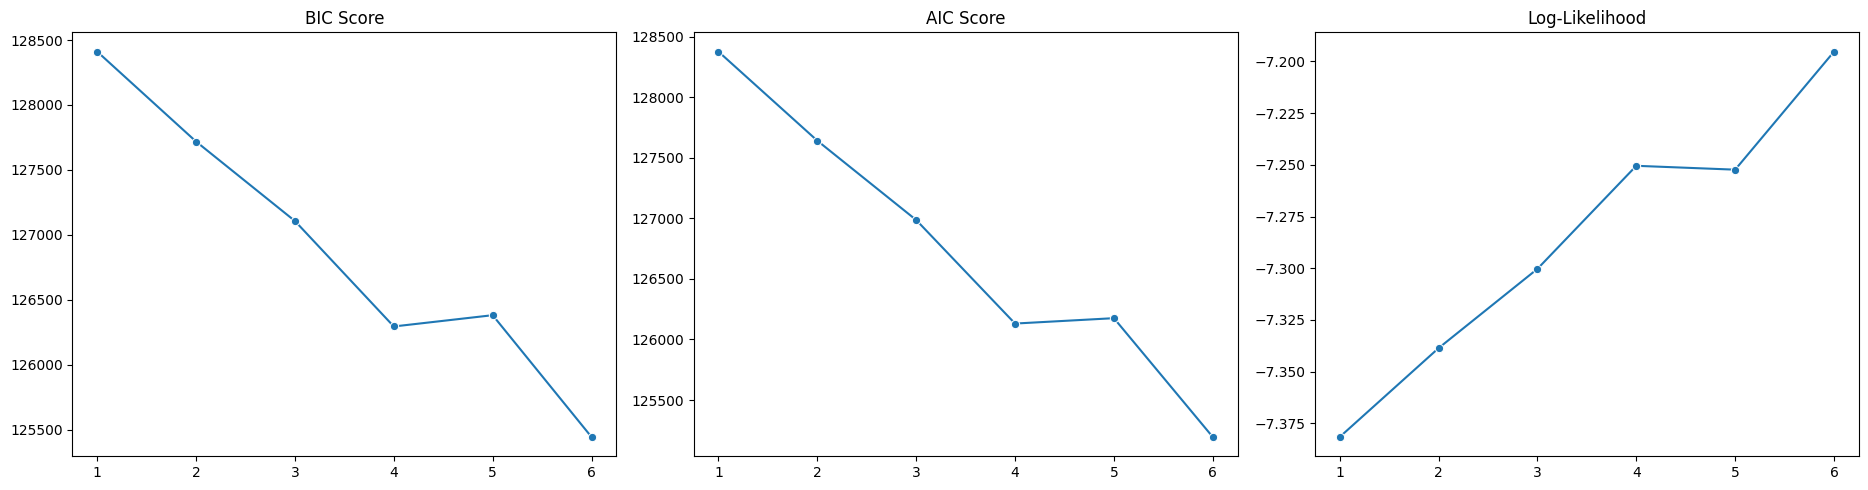

In [48]:
plt.figure(figsize=(25, 5))

# BIC Plot
plt.subplot(1, 4, 1)
sns.lineplot(x=ks, y=bics, marker='o')
plt.title('BIC Score')

# AIC Plot
plt.subplot(1, 4, 2)
sns.lineplot(x=ks, y=aics, marker='o')
plt.title('AIC Score')

# Log-Likelihood Plot
plt.subplot(1, 4, 3)
sns.lineplot(x=ks, y=lls, marker='o')
plt.title('Log-Likelihood')


plt.tight_layout()
plt.show()

The optimal value for the components is the same for all criteria, since the best number of components for BIC and AIC is the one that minimizes it and for the likelihoods the one that maximizes it.

In [41]:
dfr['profile'].value_counts()

1    1982
0    1631
5    1435
2    1425
4    1249
3     973
Name: profile, dtype: int64

In [ ]:
! pip install plotly

In [ ]:
"""3d version to observe patient profiles"""
import plotly.express as px


dfr.to_csv('Eureca2.0_umapGMM3d.csv')

# Create an interactive 3D scatter plot using plotly
fig = px.scatter_3d(dfr, x='UMAP1', y='UMAP2', z='UMAP3', color='profile', opacity=0.8)

# Update layout for better visibility
fig.update_layout(scene=dict(zaxis=dict(range=[dfr['UMAP3'].min(), dfr['UMAP3'].max()])))

# Show the interactive plot
fig.show()

In [ ]:
cdg =  dfr['profile'].value_counts(normalize=True)
cluster_distribution_gmm = dfr['profile'].value_counts(normalize=True)
print("Cluster Distribution (GMM-3d):")
print(cdg)

In [42]:
dfr.to_csv('Eureca2.0_umapGMM.csv')

In [58]:
# READING DATA
dfr = pd.read_csv('Eureca2.0_umapGMM.csv')
# dfr.drop('ordered_profile', axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


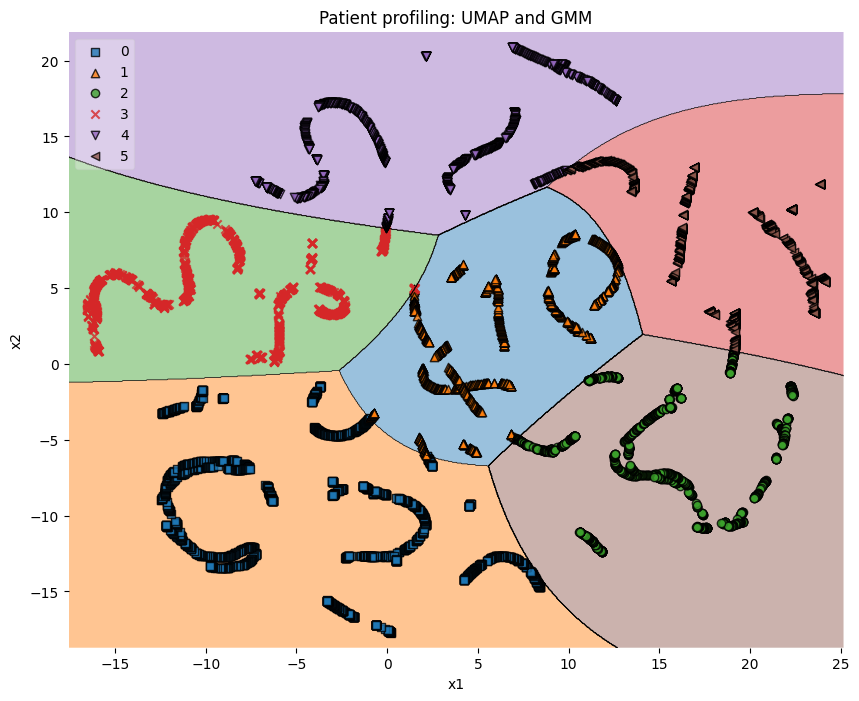

In [59]:
from mlxtend.plotting import plot_decision_regions

cdg =  dfr['profile'].value_counts(normalize=True)
ordered_cluster_indices = cdg.index
dfr['ordered_profile'] = dfr['profile'].map(dict(zip(ordered_cluster_indices, range(len(ordered_cluster_indices)))))
"""
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='ordered_profile', data=dfr, palette="Set1", s=100, alpha=0.8)
plt.title('Patient profiling: UMAP and GMM')
plt.show()
"""
plt.figure(figsize=(10, 8))
plot_decision_regions(embeddings, dfr['ordered_profile'].values, clf=gmm, legend=2)
plt.title('Patient profiling: UMAP and GMM')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

We now commence by analyzing the results.

In [46]:
cluster_distribution_gmm = dfr['profile'].value_counts(normalize=True)
print("Cluster Distribution (GMM-2d):")
print(cdg)

Cluster Distribution (GMM-2d):
1    0.227947
0    0.187579
5    0.165037
2    0.163887
4    0.143646
3    0.111903
Name: profile, dtype: float64


There are is a substantially weaker profile, which is the 3rd one that only contains 11% of samples (significantly less than the 16% had the distribution been uniform), two close to uniform ones, and two dominant ones, in particular the second one is the biggest.

In [47]:
# 2d
cluster_centers_gmm = pd.DataFrame(gmm.means_, columns=['UMAP1', 'UMAP2'])
cluster_covariance_gmm = gmm.covariances_

print("\nCluster Centers 2-d (GMM):")
print(cluster_centers_gmm)
print("\nCluster Covariance Matrices (GMM):")
for i, cov_matrix in enumerate(cluster_covariance_gmm):
    print(f"\nCluster {i} Covariance Matrix:")
    print(cov_matrix)


Cluster Centers 2-d (GMM):
       UMAP1      UMAP2
0   6.202664   1.841571
1  -4.002100  -9.122256
2  -8.381435   5.015145
3  17.682072   7.529043
4   1.939528  14.584019
5  14.830111  -6.207371

Cluster Covariance Matrices (GMM):

Cluster 0 Covariance Matrix:
[[17.36934502 10.95107313]
 [10.95107313 22.35389078]]

Cluster 1 Covariance Matrix:
[[34.9782724  -7.92368073]
 [-7.92368073 19.18502396]]

Cluster 2 Covariance Matrix:
[[26.9498148   1.41727532]
 [ 1.41727532  8.30907118]]

Cluster 3 Covariance Matrix:
[[20.75592612 -7.55940657]
 [-7.55940657 15.84296145]]

Cluster 4 Covariance Matrix:
[[36.35818237  9.37401114]
 [ 9.37401114 10.49705226]]

Cluster 5 Covariance Matrix:
[[22.98288042  4.48115064]
 [ 4.48115064 15.91738079]]


All of the profiles, have very anisotropic covariance matrices.

#### UMAP + KMEANS

Fitting KMeans to 2-d and 3-d data obtained through UMAP based on optimal silhoutte score

In [51]:
wss = []  # within-cluster sum of squares
sscores = []  # silhouette scores
ks = range(2, 8)  # Adjust the range based on your needs

for n_clusters in ks:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)
    labels = kmeans.labels_
    wss.append(kmeans.inertia_)  # Inertia is the WSS
    sscores.append(ss(embeddings, labels))

# Find the optimal number of clusters based on the elbow method (WSS)
optimal_k_wss = ks[np.argmin(wss)]

# Find the optimal number of clusters based on silhouette score
optimal_k_silhouette = ks[np.argmax(sscores)]

# KMeans clustering with optimal_k_silhouette
kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=42)
labels_silhouette = kmeans_silhouette.fit_predict(embeddings)

if np.shape(embeddings)[1] == 2:
    dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2'])
else:
    dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2', 'UMAP3'])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [61]:
dfr['profile'] = labels_silhouette

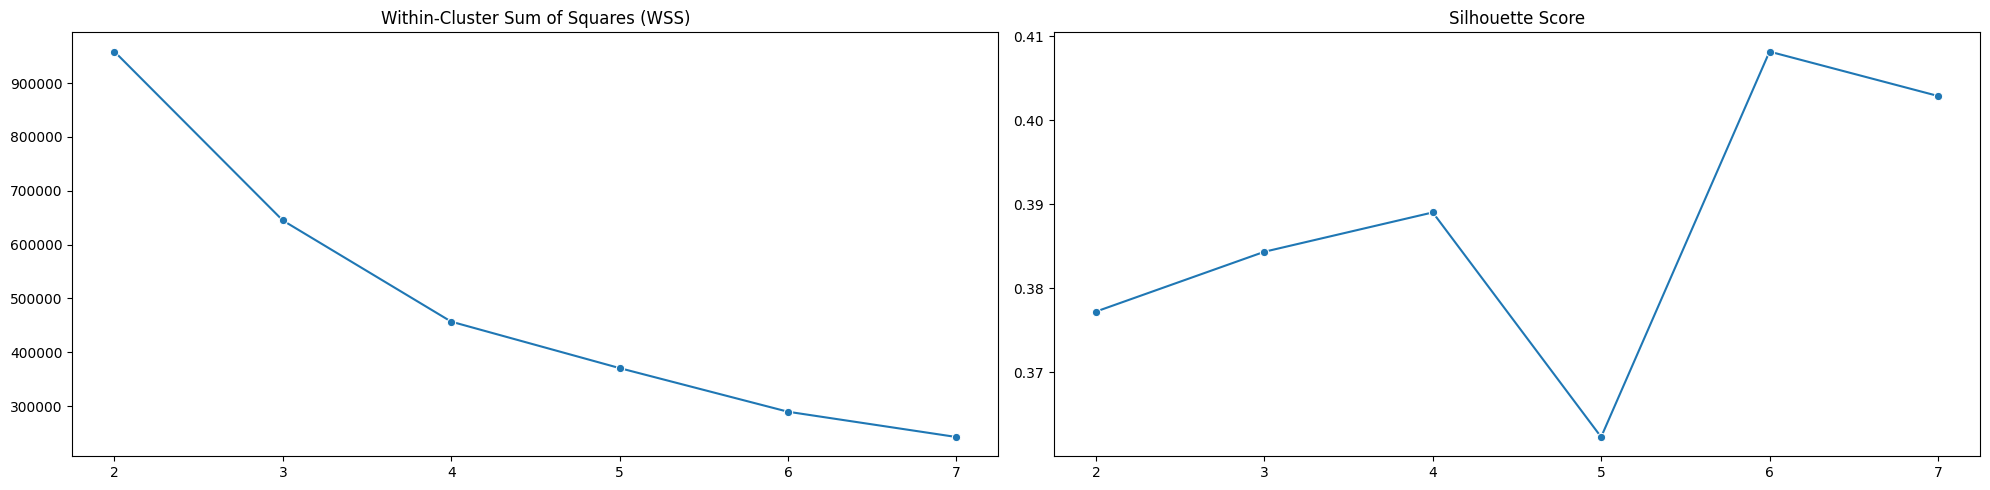

In [64]:

# Plotting
plt.figure(figsize=(20, 5))

# WSS Plot
plt.subplot(1, 2, 1)
sns.lineplot(x=ks, y=wss, marker='o')
plt.title('Within-Cluster Sum of Squares (WSS)')

# Silhouette Score Plot
plt.subplot(1, 2, 2)
sns.lineplot(x=ks, y=sscores, marker='o')
plt.title('Silhouette Score')


plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


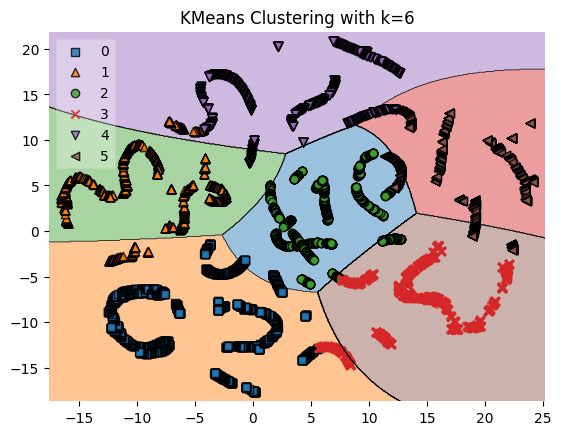

In [66]:
# KMeans clustering with optimal_k_wss Plot

cdg =  dfr['profile'].value_counts(normalize=True)
ordered_cluster_indices = cdg.index
dfr['ordered_profile'] = dfr['profile'].map(dict(zip(ordered_cluster_indices, range(len(ordered_cluster_indices)))))
plot_decision_regions(embeddings, dfr['ordered_profile'].values, clf=gmm, legend=2)
# sns.scatterplot(x=dfr.iloc[:, 0], y=dfr.iloc[:, 1], hue=labels_wss, palette='viridis')
plt.title(f'KMeans Clustering with k={optimal_k_silhouette}')
plt.show()